# Install libraries

In [ ]:
!pip install --upgrade pip setuptools
!pip install recommenders
!pip install papermill
!pip install scrapbook
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 64.5 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.6/335.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 kB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━

# Download Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mercurio117","key":"aa32c9add37b4c6d6128fd12fa1a54ad"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f articles.csv
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f customers.csv
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f transactions_train.csv

  0% 0.00/4.26M [00:00<?, ?B/s]
100% 4.26M/4.26M [00:00<00:00, 146MB/s]
 82% 80.0M/97.9M [00:00<00:00, 218MB/s]
100% 97.9M/97.9M [00:00<00:00, 141MB/s]
 97% 569M/584M [00:03<00:00, 150MB/s]
100% 584M/584M [00:03<00:00, 165MB/s]


In [ ]:
!mkdir H-and-M
!unzip articles.csv.zip -d H-and-M
!unzip customers.csv.zip -d H-and-M
!unzip transactions_train.csv.zip -d H-and-M

Archive:  articles.csv.zip
  inflating: H-and-M/articles.csv    
Archive:  customers.csv.zip
  inflating: H-and-M/customers.csv   
Archive:  transactions_train.csv.zip
  inflating: H-and-M/transactions_train.csv  


# Filter Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
transactions = pd.read_csv("transactions_train.csv")

In [ ]:
transactions.tail()

,t_dat,customer_id,article_id,price,sales_channel_id
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1
31788323,2020-09-22,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,898573003,0.033881,2


Last Day 2020-09-22

Last Week 2020-09-15

Select last two month to train the model

In [ ]:
df_train_orig = transactions[(transactions['t_dat'] >= '2020-08-01') & (transactions['t_dat'] < '2020-09-01')]
df_test = transactions[transactions['t_dat'] >='2020-09-01']

In [ ]:
def filter_min_items(df, min_items):
  customers = df['customer_id'].values
  values, counts = np.unique(customers, return_counts=True)
  print("Original customers:", len(values))
  idxs = np.where(counts>=min_items)
  print("Customers after filtering:", len(idxs[0]))
  df_temp = df.set_index('customer_id')
  df_temp = df_temp.loc[values[idxs]]
  df_temp.reset_index(inplace=True)

  return df_temp

def create_rating_table(df):
  df = df.drop(["t_dat", "price", "sales_channel_id"], axis=1)
  df = df.groupby(["customer_id", "article_id"], as_index=False).count()
  df["rating"] = 1
  df.rename(columns={'customer_id':'userID', 'article_id':'itemID'}, inplace=True)
  return df

def filter_by_customer(train, test):
  le = LabelEncoder()
  customers_train = np.unique(train['customer_id'].values)
  customers_test = np.unique(test['customer_id'].values)
  customers = np.intersect1d(customers_train, customers_test)
  le.fit(customers)
  print("Original customers:", len(customers_train))
  train = train.set_index('customer_id')
  train = train.loc[customers]
  train.reset_index(inplace=True)
  new_customers = np.unique(train['customer_id'].values)
  print("Customers after filtering:", len(new_customers))
  test = test.set_index('customer_id')
  test = test.loc[customers]
  test.reset_index(inplace=True)

  train = create_rating_table(train)
  train['userID'] = le.transform(train['userID'])
  test = create_rating_table(test)
  test['userID'] = le.transform(test['userID'])

  return train, test, le

In [ ]:
min_items = 10
df_train = filter_min_items(df_train_orig, min_items)
df_train.head()

In [ ]:
train, test, le = filter_by_customer(df_train, df_test)

print("\nTest dataset")
print("Before filtering:", len(np.unique(test['userID'].values)))
#Filter out any users or items in the test set that do not appear in the training set.
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]
print("After filtering:", len(np.unique(test['userID'].values)))

In [ ]:
train.head()

,userID,itemID,rating
0,0,572998001,1
1,0,572998007,1
2,0,684824006,1
3,0,713253003,1
4,0,808685002,1


In [ ]:
test.head()

,userID,itemID,rating
1,0,734592001,1
4,0,865929003,1
5,0,888024005,1
6,0,909869004,1
7,0,923134003,1


In [ ]:
train.to_csv("Train.csv")
test.to_csv("Test.csv")

# Train Model NCF

In [ ]:
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.constants import SEED as DEFAULT_SEED

In [ ]:
DEFAULT_SEED

42

In [ ]:
# Initial parameters original RUN
TOP_K = 12
EPOCHS = 5
BATCH_SIZE = 64
SEED = DEFAULT_SEED
LEARNING_RATE = 1e-3

In [ ]:
# Initial parameters 2nd RUN
TOP_K = 12
EPOCHS = 5
BATCH_SIZE = 128
SEED = DEFAULT_SEED
LEARNING_RATE = 0.005

In [ ]:
# Initial parameters 3rd RUN
TOP_K = 12
EPOCHS = 10
BATCH_SIZE = 128
SEED = DEFAULT_SEED
LEARNING_RATE = 0.009

In [ ]:
# Initial parameters 4th RUN
TOP_K = 12
EPOCHS = 15
BATCH_SIZE = 256
SEED = DEFAULT_SEED
LEARNING_RATE = 1e-4

In [ ]:
# Initial parameters 5th RUN
TOP_K = 12
EPOCHS = 20
BATCH_SIZE = 64
SEED = DEFAULT_SEED
LEARNING_RATE = 1e-2

In [ ]:
data = NCFDataset(train_file = "Train.csv", test_file = "Test.csv", seed=SEED)

INFO:recommenders.models.ncf.dataset:Indexing Train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing Test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing Test_full.csv ...


In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    verbose=1,
    seed=SEED
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
from recommenders.utils.timer import Timer
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))
#model.save(dir_name='/content/NCF')

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 1 [367.79s]: train_loss = 0.410225 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 2 [240.14s]: train_loss = 0.375258 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 3 [241.24s]: train_loss = 0.345842 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 4 [240.81s]: train_loss = 0.325618 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [239.08s]: train_loss = 0.310880 


Took 1329.083232959 seconds for training.


In [ ]:
test.head()

,userID,itemID,rating
1,0,734592001,1
4,0,865929003,1
5,0,888024005,1
6,0,909869004,1
7,0,923134003,1


In [ ]:
def predict_k_user(model, userID, train, k):
  items = list(train.itemID.unique())
  predictions=[]
  for i, item in enumerate(items):
    predictions.append([userID, item, model.predict(userID, item)])
  predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
  predictions.sort_values(by='prediction', ascending=False, inplace=True)
  return predictions#.head(k)

def predict_perro(model, users, train, topK):
  items = list(train.itemID.unique())
  predictions = []
  for user in users:
    user_items = list(train[train['userID'] == user].itemID.unique())
    for item in items:
      if item not in user_items:
        predictions.append([user, item, model.predict(user, item)])

  predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

  predictions["rank"] = predictions.groupby("userID")["prediction"].rank("dense", ascending=False)
  predictions = predictions[predictions['rank'] <= topK ]

  return predictions

In [ ]:
n_users = 50

userID = train['userID'].unique()[0:n_users]
predictions = predict_perro(model, userID, train, TOP_K)
predictions

In [ ]:
test_temp = test.set_index('userID')
test_temp = test_temp.loc[userID]
test_temp.reset_index(inplace=True)
test_temp.head()

,userID,itemID,rating
0,0,734592001,1
1,0,865929003,1
2,0,888024005,1
3,0,909869004,1
4,0,923134003,1


In [ ]:
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

eval_map = map_at_k(test_temp, predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_temp, predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_temp, predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000636
Precision@K:	0.003333
Recall@K:	0.003485


## Kaggle submission

In [ ]:
predictions['userID'] = le.inverse_transform(predictions['userID'].values)
predictions.reset_index(drop=True, inplace=True)
predictions.sample(5)

,userID,itemID,prediction,rank
48,001c1f8d70782f450524d3b3f404474dbd4a7d0d2ad78a...,817361007,0.934947,5.0
73,00250644a9628fb8c4aebabf555d3caabe44c99c74fbcf...,884319006,0.814418,11.0
206,005e89af159f63c1280904d911e7f872683ab6223ecf33...,916468003,0.952398,1.0
596,00f1c3895749444bd89d21b2892f26e87efbe93464d068...,794468001,0.937441,10.0
236,0064cd1ee810d4caabd1182a8f177479b82b18961bd76b...,741040001,0.947676,10.0


# Train Model ViBae

In [ ]:
import sys
import os
import torch
import cornac
import papermill as pm
import scrapbook as sb
import pandas as pd
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

print("System version: {}".format(sys.version))
print("PyTorch version: {}".format(torch.__version__))
print("Cornac version: {}".format(cornac.__version__))

System version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
PyTorch version: 1.11.0+cu113
Cornac version: 1.14.2


In [ ]:
# top k items to recommend 1
TOP_K = 12

# Model parameters
LATENT_DIM = 50
ENCODER_DIMS = [100]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [ ]:
# top k items to recommend 2
TOP_K = 12

# Model parameters
LATENT_DIM = 40
ENCODER_DIMS = [90]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.005

In [ ]:
# top k items to recommend 3
TOP_K = 12

# Model parameters
LATENT_DIM = 60
ENCODER_DIMS = [110]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.009

In [ ]:
# top k items to recommend 4
TOP_K = 12

# Model parameters
LATENT_DIM = 100
ENCODER_DIMS = [200]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 20
BATCH_SIZE = 512
LEARNING_RATE = 0.01

In [ ]:
# top k items to recommend 5
TOP_K = 12

# Model parameters
LATENT_DIM = 5
ENCODER_DIMS = [10]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

In [ ]:
train = pd.read_csv('Train.csv')

In [ ]:
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

print('Number of  customers: {}'.format(train_set.num_users))
print('Number of articles: {}'.format(train_set.num_items))

Number of  customers: 186577
Number of articles: 13462


In [ ]:
bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)

In [ ]:
with Timer() as t:
    bivae.fit(train_set)
print("Took {} seconds for training.".format(t))

  0%|          | 0/5 [00:00<?, ?it/s]

Took 227.7747 seconds for training.


In [ ]:
def predict_gato(bivae, users, train, k):
  user_idxs = range(len(users))
  items = list(train.itemID.unique())
  items_idxs = range(len(items))
  predictions = []

  for user_idx in user_idxs:
    user_items = list(train[train['userID'] == users[user_idx]].itemID.unique())
    items_enc, prediction = bivae.rank(user_idx=user_idx, item_indices=items_idxs)
    for i, items_idx in enumerate(items_idxs):
      item = items[items_idx]
      if item not in user_items:
        predictions.append( [users[user_idx], items[items_idx], prediction[i]] )
  
  predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

  predictions["rank"] = predictions.groupby("userID")["prediction"].rank("dense", ascending=False)
  predictions = predictions[predictions['rank'] <= k ]
  return predictions

In [ ]:
predictions_bivae = predict_gato(bivae, userID, train, TOP_K)
predictions_bivae

,userID,itemID,prediction,rank
9,0,908466004,0.002034,2.0
73,0,703619001,0.002091,1.0
123,0,868747001,0.001962,4.0
206,0,640664005,0.001945,8.0
235,0,836605002,0.001932,9.0
...,...,...,...,...
978192,49,874754015,0.007767,3.0
978445,49,695421008,0.007553,6.0
978446,49,710058009,0.007553,6.0
978447,49,796479002,0.007553,6.0


In [ ]:
eval_map = map_at_k(test_temp, predictions_bivae, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_temp, predictions_bivae, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_temp, predictions_bivae, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000


## Kaggle submission

In [ ]:
predictions_bivae['userID'] = le.inverse_transform(predictions_bivae['userID'].values)
predictions_bivae.reset_index(drop=True, inplace=True)
predictions_bivae.sample(5)

,userID,itemID,prediction,rank
508,00c160fd797be9c52491373b16ec194d4edb129c57266e...,850917001,0.999974,9.0
266,00754012108569f9c99871720111a2b50aa7b6ebebe2a4...,882757003,0.999657,11.0
582,00de0f442480958d4c86892efe81b5871beb79805dbdd0...,921906001,0.999873,3.0
476,00bce12709bdc1536ee25bc63e229d3746960b20cbbb75...,924250001,0.991922,11.0
400,009a85913aa6f503ed0d2b5ac02ab919d6565bbbaa934a...,850917001,0.992643,10.0


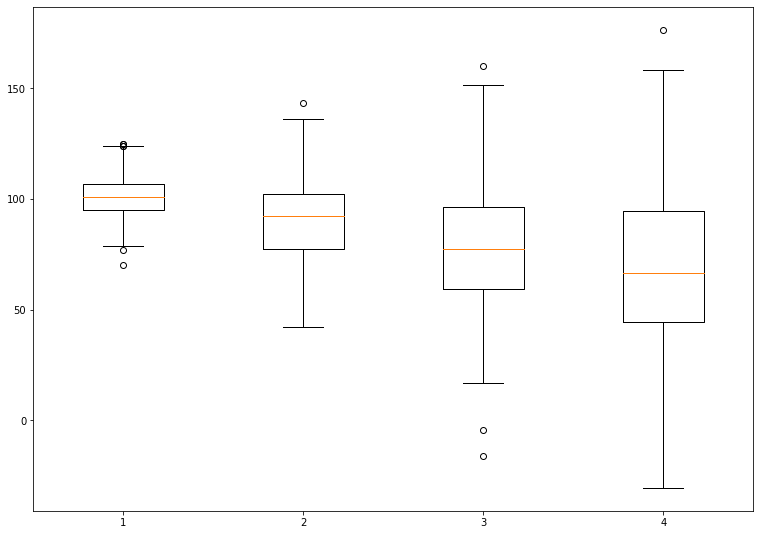

In [ ]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)
 
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

In [ ]:
mAP_BiVAE = [[0.004321,0.005767,0.013306,0.000833,0]]
recall_BiVAE = [0.030485,0.024318,0.041250,0.0025,0]
precision_BiVAE = [0.006667,0.005,0.006667,0.001667,0]

In [ ]:
import numpy as np
arr = np.array(mAP_BiVAE)
arr2 = np.array(recall_BiVAE)
arr3= np.array(precision_BiVAE)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


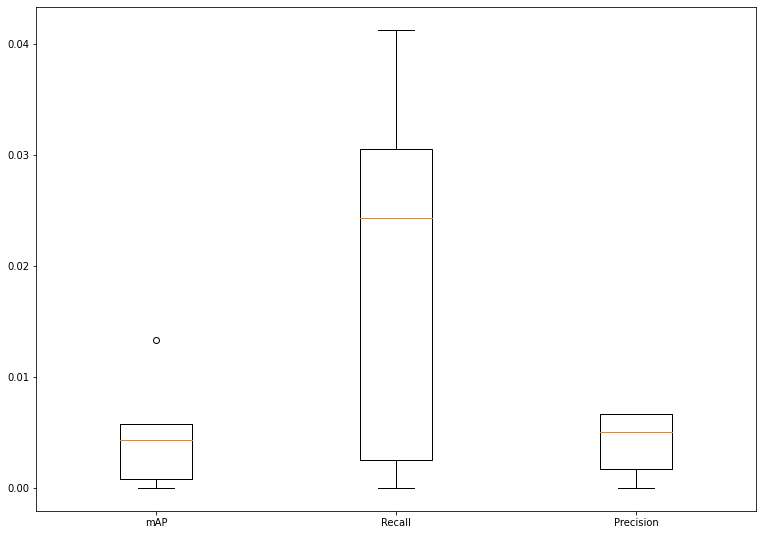

In [ ]:
data = [arr,arr2,arr3]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xticks([1, 2, 3], ['mAP', 'Recall', 'Precision'])
# show plot
plt.show()

In [ ]:
mAP_NCF = [0.008121,0.005587,0.002979,0.002388,0.000636]
recall_NCF = [0.03569,0.027803,0.014457,0.013194,0.003485]
precision_NCF = [0.011667,0.008333,0.01,0.008333,0.003333]

arr4 = np.array(mAP_NCF)
arr5 = np.array(recall_NCF)
arr6= np.array(precision_NCF)

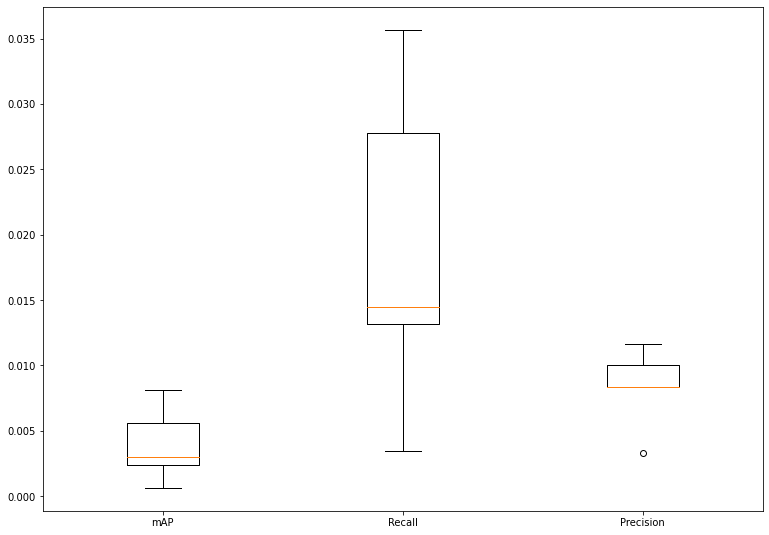

In [ ]:
data = [arr4,arr5,arr6]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
plt.xticks([1, 2, 3], ['mAP', 'Recall', 'Precision'])
# show plot
plt.show()